In [492]:
#--------------------------------------------------------------------------------------------
# Rutgers Fintech Project-2 task is to develop a Trading Algorithm in Python to automatically 
# execute Buy/Sell orders based on a defined trading strategy.
# 
# This submission implements 2 different Trading Strategies and compares the Returns of each.
# The first is based on DMAC (Golden + Death Crosses) and the seccond is a simple 'Buy-on-Dips, Sell-on-Highs" strategy.
# The commodity being bought/sold is Ethereum (ETH).
# 
# Each of the 2 Trading Strategy implmentations follow a similar pattern:
#  1. Gather Data: We will be using historical price data downloaded from BINANCE (by Justin)
#  2. Preprocess the Data: E.g., drop Nulls, choose/drop certain columns using Pandas
#  3. Implement the Trading Strategy: Write code to implement specific trading strategy, using the predictions from model to decide when to buy/sell Ethereum.
#  4. Test the strategy: Evaluate the trained model and see how well it performs by simulating trading strategy on historical data (backtesting).
#  5. Compare the Cumulative Returns when more than one Trading Strategy is used.
#--------------------------------------------------------------------------------------------

In [493]:
# import all required Python libraries
import pandas as pd
import numpy as np
import hvplot.pandas
from sklearn.cluster import KMeans
from finta import TA

In [494]:
# Import historical Ethereum prices (earlier downloaded from BINANCE via APIs) into a dataframe
from pathlib import Path
filepath="./Resources/eth.csv"
eth_df = pd.read_csv(
    Path(filepath), 
    index_col='time', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the newly-created dataframe
eth_df

,open,high,low,close,volume
time,,,,,
2019-09-23 23:59:59.999,209.55,209.55,209.55,209.55,0.01000
2019-09-24 23:59:59.999,195.50,195.50,152.56,167.09,2224.36708
2019-09-25 23:59:59.999,166.84,174.15,163.18,170.00,181.60286
2019-09-26 23:59:59.999,169.95,170.77,153.07,166.69,545.45350
2019-09-27 23:59:59.999,166.34,175.54,161.44,173.69,630.91688
...,...,...,...,...,...
2022-11-27 23:59:59.999,1205.19,1223.05,1189.13,1193.83,654.26480
2022-11-28 23:59:59.999,1194.92,1198.52,1151.39,1168.13,1260.68583
2022-11-29 23:59:59.999,1167.25,1225.00,1158.51,1216.37,1504.19549


In [495]:
signals_df = eth_df.loc[:,['close']]
signals_df['actual returns'] = signals_df['close'].pct_change()
# signals_df = signals_df.dropna()

# Review the updated dataframe
signals_df

,close,actual returns
time,,
2019-09-23 23:59:59.999,209.55,NaN
2019-09-24 23:59:59.999,167.09,-0.202625
2019-09-25 23:59:59.999,170.00,0.017416
2019-09-26 23:59:59.999,166.69,-0.019471
2019-09-27 23:59:59.999,173.69,0.041994
...,...,...
2022-11-27 23:59:59.999,1193.83,-0.009204
2022-11-28 23:59:59.999,1168.13,-0.021527
2022-11-29 23:59:59.999,1216.37,0.041297


In [496]:
# Set the Short window and long windows to 50 and 200 respectively (to implement 'Golden Cross' DMAC strategy)
short_window = 50
long_window = 200

# Generate the Short and Long moving averages (50 and 200 days, respectively)
signals_df['SMA50'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA200'] = signals_df['close'].rolling(window=long_window).mean()

In [497]:
# Prepopulate the `Signal` for trading
signals_df['Signal'] = 0.0

# Generate the trading signal 0 or 1, where 1 is when SHORT window (SMA50) is > the LONG (SMA200); 0 otherwise
signals_df['Signal'][short_window:] = np.where(
    signals_df['SMA50'][short_window:] > signals_df['SMA200'][short_window:], 1.0, 0.0
)

In [498]:
# Calculate the points in time when the Signal value changes; Mark Trade ENTRY(1) and EXIT(-1) points
signals_df['Entry/Exit'] = signals_df['Signal'].diff()

In [499]:
# Visualize exit position relative to close price
exit = signals_df[signals_df['Entry/Exit'] == -1.0]['close'].hvplot.scatter(
    color='orange',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = signals_df[signals_df['Entry/Exit'] == 1.0]['close'].hvplot.scatter(
    color='purple',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = signals_df[['close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
moving_avgs = signals_df[['SMA50', 'SMA200']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Create the overlay plot
entry_exit_plot = security_close * moving_avgs * entry * exit

# Show the plot with a title
entry_exit_plot.opts(
    title="Ethereum - SMA50, SMA200, Entry & Exit Points"
)

:Overlay
   .Curve.I          :Curve   [time]   (close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [time]   (value)
   .Scatter.Close.I  :Scatter   [time]   (close)
   .Scatter.Close.II :Scatter   [time]   (close)

In [500]:
# Set the initial_capital to 200000 and Set the share_size/lot to 500
initial_capital = float(200000)
share_size = 500

# Buy a share-size/lot position when the DMAC Signal equals 1, else `Position` should be zero (Sell)
signals_df['Position'] = share_size * signals_df['Signal']

# Determine the points in time where a share lot position is bought or sold
signals_df['Entry/Exit Position'] = signals_df['Position'].diff()

# Multiply the close price by the number of shares held, or the Position
signals_df['Portfolio Holdings'] = signals_df['close'] * signals_df['Position']

# Subtract the amount of either the cost or proceeds of the trade from the initial capital invested
signals_df['Portfolio Cash'] = initial_capital - (signals_df['close'] * signals_df['Entry/Exit Position']).cumsum() 

# Calculate the total portfolio value by adding the portfolio cash to the portfolio holdings (or investments)
signals_df['Portfolio Total'] = signals_df['Portfolio Cash'] + signals_df['Portfolio Holdings']

# Calculate the portfolio daily returns
signals_df['Portfolio Daily Returns'] = signals_df['Portfolio Total'].pct_change()

# Calculate the portfolio cumulative returns
signals_df['Portfolio Cumulative Returns'] = (1 + signals_df['Portfolio Daily Returns']).cumprod() - 1

# Review the DataFrame
signals_df

,close,actual returns,SMA50,SMA200,Signal,Entry/Exit,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
time,,,,,,,,,,,,,
2019-09-23 23:59:59.999,209.55,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN
2019-09-24 23:59:59.999,167.09,-0.202625,NaN,NaN,0.0,0.0,0.0,0.0,0.0,200000.0,200000.0,NaN,NaN
2019-09-25 23:59:59.999,170.00,0.017416,NaN,NaN,0.0,0.0,0.0,0.0,0.0,200000.0,200000.0,0.0,0.000000
2019-09-26 23:59:59.999,166.69,-0.019471,NaN,NaN,0.0,0.0,0.0,0.0,0.0,200000.0,200000.0,0.0,0.000000
2019-09-27 23:59:59.999,173.69,0.041994,NaN,NaN,0.0,0.0,0.0,0.0,0.0,200000.0,200000.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-27 23:59:59.999,1193.83,-0.009204,1340.4520,1487.88700,0.0,0.0,0.0,0.0,0.0,1162505.0,1162505.0,0.0,4.812525
2022-11-28 23:59:59.999,1168.13,-0.021527,1337.3610,1483.93515,0.0,0.0,0.0,0.0,0.0,1162505.0,1162505.0,0.0,4.812525
2022-11-29 23:59:59.999,1216.37,0.041297,1335.8730,1479.98445,0.0,0.0,0.0,0.0,0.0,1162505.0,1162505.0,0.0,4.812525


In [501]:
# Visualize exit position relative to total portfolio value
exit = signals_df[signals_df['Entry/Exit'] == -1.0]['Portfolio Total'].hvplot.scatter(
    color='orange',
    marker='v',
    legend=False,
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize entry position relative to total portfolio value
entry = signals_df[signals_df['Entry/Exit'] == 1.0]['Portfolio Total'].hvplot.scatter(
    color='purple',
    marker='^',
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize the value of the total portfolio
total_portfolio_value = signals_df[['Portfolio Total']].hvplot(
    line_color='lightgray',
    ylabel='Total Portfolio Value',
    xlabel='Date',
    width=1000,
    height=400
)

# Overlay the plots
portfolio_entry_exit_plot = total_portfolio_value * entry * exit
portfolio_entry_exit_plot.opts(
    title="Ethereum Project-2 Algorithm - Total Portfolio Value",
    yformatter='%.0f'
)

:Overlay
   .Curve.I                    :Curve   [time]   (Portfolio Total)
   .Scatter.Portfolio_Total.I  :Scatter   [time]   (Portfolio Total)
   .Scatter.Portfolio_Total.II :Scatter   [time]   (Portfolio Total)

In [502]:
## Set Up the Portfolio-Level Risk/Reward Evaluation Metrics

# Create a list for the column name
columns = ["Backtest"]

# Create a list holding the names of the new evaluation metrics
metrics = [
    "Annualized Return",
    "Cumulative Returns",
    "Annual Volatility",
    "Sharpe Ratio",
    "Sortino Ratio"]

# Initialize the DataFrame with index set to the evaluation metrics and the column
portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)

# Review the (currently Null values) DataFrame
portfolio_evaluation_df

,Backtest
Annualized Return,NaN
Cumulative Returns,NaN
Annual Volatility,NaN
Sharpe Ratio,NaN
Sortino Ratio,NaN


In [503]:
# Calculate annualized return
portfolio_evaluation_df.loc["Annualized Return"] = (
    signals_df["Portfolio Daily Returns"].mean() * 252
)

# Calculate cumulative return
portfolio_evaluation_df.loc["Cumulative Returns"] = signals_df["Portfolio Cumulative Returns"][-1]

# Calculate annual volatility
portfolio_evaluation_df.loc["Annual Volatility"] = (
    signals_df["Portfolio Daily Returns"].std() * np.sqrt(252)
)

# Calculate Sharpe ratio
portfolio_evaluation_df.loc["Sharpe Ratio"] = (
    signals_df["Portfolio Daily Returns"].mean() * 252) / (
    signals_df["Portfolio Daily Returns"].std() * np.sqrt(252)
)

In [504]:
# Create a DataFrame that contains the Portfolio Daily Returns column
sortino_ratio_df = signals_df[["Portfolio Daily Returns"]].copy()

# Create a column to hold downside return values
sortino_ratio_df.loc[:,"Downside Returns"] = 0

# Find Portfolio Daily Returns values less than 0,
# square those values, and add them to the Downside Returns column
sortino_ratio_df.loc[sortino_ratio_df["Portfolio Daily Returns"] < 0,
                     "Downside Returns"] = sortino_ratio_df["Portfolio Daily Returns"]**2

# Review the DataFrame
sortino_ratio_df

,Portfolio Daily Returns,Downside Returns
time,,
2019-09-23 23:59:59.999,NaN,0.0
2019-09-24 23:59:59.999,NaN,0.0
2019-09-25 23:59:59.999,0.0,0.0
2019-09-26 23:59:59.999,0.0,0.0
2019-09-27 23:59:59.999,0.0,0.0
...,...,...
2022-11-27 23:59:59.999,0.0,0.0
2022-11-28 23:59:59.999,0.0,0.0
2022-11-29 23:59:59.999,0.0,0.0


In [505]:
# Review the (updated) Portfolio Evaluation DataFrame
portfolio_evaluation_df

,Backtest
Annualized Return,0.519132
Cumulative Returns,4.812525
Annual Volatility,0.523763
Sharpe Ratio,0.991158
Sortino Ratio,NaN


In [506]:
# Initialize trade evaluation DataFrame with columns
trade_evaluation_df = pd.DataFrame(
    columns=[
        "Crypto",
        "Entry Date",
        "Exit Date",
        "Trade Lot Size",
        "Entry Price",
        "Exit Price",
        "Entry Portfolio Holding",
        "Exit Portfolio Holding",
        "Profit/Loss"]
)

In [507]:
%%capture --no-display
# the above line suppresses Warning messages in the output window for this cell

# Loop through signal DataFrame
# If `Entry/Exit` is 1, set ENTRY trade metrics
# Else if `Entry/Exit` is -1, set EXIT trade metrics and calculate profit
# Then append the record to the trade evaluation DataFrame
for index, row in signals_df.iterrows():
    if row["Entry/Exit"] == 1:
        entry_date = index
        entry_portfolio_holding = row["Portfolio Holdings"]
        share_size = row["Entry/Exit Position"]
        entry_share_price = row["close"]
    elif row["Entry/Exit"] == -1:
        exit_date = index
        exit_portfolio_holding = abs(row["close"] * row["Entry/Exit Position"])
        exit_share_price = row["close"]
        profit_loss = exit_portfolio_holding - entry_portfolio_holding
        trade_evaluation_df = trade_evaluation_df.append(
            {
                "Crypto": "ETH",
                "Entry Date": entry_date,
                "Exit Date": exit_date,
                "Trade Lot Size": share_size,
                "Entry Price": entry_share_price,
                "Exit Price": exit_share_price,
                "Entry Portfolio Holding": entry_portfolio_holding,
                "Exit Portfolio Holding": exit_portfolio_holding,
                "Profit/Loss": profit_loss
            },
            ignore_index=True)

# Print the DataFrame
trade_evaluation_df

,Crypto,Entry Date,Exit Date,Trade Lot Size,Entry Price,Exit Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss
0,ETH,2020-04-09 23:59:59.999000,2020-04-11 23:59:59.999000,500.0,170.21,158.41,85105.0,79205.0,-5900.0
1,ETH,2020-05-14 23:59:59.999000,2021-08-02 23:59:59.999000,500.0,203.1,2606.52,101550.0,1303260.0,1201710.0
2,ETH,2021-08-08 23:59:59.999000,2022-01-28 23:59:59.999000,500.0,3012.65,2546.04,1506325.0,1273020.0,-233305.0


In [508]:
# This section will attempt another Trading Strategy of "Buy on Dips, Sell on Highs" strategy
# We'll first calculate the rolling maximum and minimum over the past 10 days, and a % change in price over the past 10 days. 
# It then executes the trading strategy and calculates the returns of the strategy.
# Finally, it graphically plots the Cumulative Returns.

# Reload the Ethereum pricing data (earlier downloaded from BINANCE via APIs) and reset the 'signals' dataframe
filepath="./Resources/eth.csv"
eth_df = pd.read_csv(
    Path(filepath), 
    index_col='time', 
    infer_datetime_format=True, 
    parse_dates=True
)

signals_df = eth_df.loc[:,['close']]
signals_df = signals_df.dropna()

# Review the dataframe
signals_df

,close
time,
2019-09-23 23:59:59.999,209.55
2019-09-24 23:59:59.999,167.09
2019-09-25 23:59:59.999,170.00
2019-09-26 23:59:59.999,166.69
2019-09-27 23:59:59.999,173.69
...,...
2022-11-27 23:59:59.999,1193.83
2022-11-28 23:59:59.999,1168.13
2022-11-29 23:59:59.999,1216.37


In [509]:
# Calculate the Rolling Maximum and Minimum over the past 10 days
signals_df['max10'] = signals_df['close'].rolling(window=10).max()
signals_df['min10'] = signals_df['close'].rolling(window=10).min()

In [510]:
# Calculate the % change in Price over the past 10 days
signals_df['price_change'] = signals_df['close'].pct_change(periods=10)

# Review the updated dataframe
signals_df

,close,max10,min10,price_change
time,,,,
2019-09-23 23:59:59.999,209.55,NaN,NaN,NaN
2019-09-24 23:59:59.999,167.09,NaN,NaN,NaN
2019-09-25 23:59:59.999,170.00,NaN,NaN,NaN
2019-09-26 23:59:59.999,166.69,NaN,NaN,NaN
2019-09-27 23:59:59.999,173.69,NaN,NaN,NaN
...,...,...,...,...
2022-11-27 23:59:59.999,1193.83,1217.94,1109.36,-0.005299
2022-11-28 23:59:59.999,1168.13,1217.94,1109.36,-0.037150
2022-11-29 23:59:59.999,1216.37,1216.37,1109.36,-0.001289


In [511]:
# Create a column that indicates whether the Price has 'increased' over the past 10 days
signals_df['price_up'] = signals_df['price_change'] > 0

# Review the updated dataframe
signals_df

,close,max10,min10,price_change,price_up
time,,,,,
2019-09-23 23:59:59.999,209.55,NaN,NaN,NaN,False
2019-09-24 23:59:59.999,167.09,NaN,NaN,NaN,False
2019-09-25 23:59:59.999,170.00,NaN,NaN,NaN,False
2019-09-26 23:59:59.999,166.69,NaN,NaN,NaN,False
2019-09-27 23:59:59.999,173.69,NaN,NaN,NaN,False
...,...,...,...,...,...
2022-11-27 23:59:59.999,1193.83,1217.94,1109.36,-0.005299,False
2022-11-28 23:59:59.999,1168.13,1217.94,1109.36,-0.037150,False
2022-11-29 23:59:59.999,1216.37,1216.37,1109.36,-0.001289,False


In [512]:
# Codify a Trading Strategy based on the "Buy-on-Dips, Sell-on-Highs" plan
signals_df['strategy'] = (signals_df['close'] == signals_df['min10']) | (signals_df['close'] == signals_df['max10'])

# Calculate the points in time when the Signal value changes; Mark Trade ENTRY(1) and EXIT(-1) points
signals_df['Entry/Exit'] = np.where(signals_df['strategy'].diff()==0, -1, 1)

# Review the updated dataframe
signals_df

,close,max10,min10,price_change,price_up,strategy,Entry/Exit
time,,,,,,,
2019-09-23 23:59:59.999,209.55,NaN,NaN,NaN,False,False,1
2019-09-24 23:59:59.999,167.09,NaN,NaN,NaN,False,False,-1
2019-09-25 23:59:59.999,170.00,NaN,NaN,NaN,False,False,-1
2019-09-26 23:59:59.999,166.69,NaN,NaN,NaN,False,False,-1
2019-09-27 23:59:59.999,173.69,NaN,NaN,NaN,False,False,-1
...,...,...,...,...,...,...,...
2022-11-27 23:59:59.999,1193.83,1217.94,1109.36,-0.005299,False,False,-1
2022-11-28 23:59:59.999,1168.13,1217.94,1109.36,-0.037150,False,False,-1
2022-11-29 23:59:59.999,1216.37,1216.37,1109.36,-0.001289,False,True,1


In [513]:
# Set the initial_capital to 200000 and Set the share_size/lot to 500
initial_capital = float(200000)
share_size = 500

# Buy a share-size/lot position when the Strategy Signal equals 1, else `Position` should be zero (Sell)
signals_df['Position'] = share_size * np.where(signals_df['strategy']==1, 1, -1)

# Determine the points in time where a share lot position is bought or sold
signals_df['Entry/Exit Position'] = signals_df['Position'].diff()

# Multiply the close price by the number of shares held, or the Position
signals_df['Portfolio Holdings'] = signals_df['close'] * signals_df['Position']

# Subtract the amount of either the cost or proceeds of the trade from the initial capital invested
signals_df['Portfolio Cash'] = initial_capital - (signals_df['close'] * signals_df['Entry/Exit Position']).cumsum() 

# Calculate the total portfolio value by adding the portfolio cash to the portfolio holdings (or investments)
signals_df['Portfolio Total'] = signals_df['Portfolio Cash'] + signals_df['Portfolio Holdings']

# Calculate the portfolio daily returns
signals_df['Portfolio Daily Returns'] = signals_df['Portfolio Total'].pct_change()

# Calculate the portfolio cumulative returns
signals_df['Portfolio Cumulative Returns'] = (1 + signals_df['Portfolio Daily Returns']).cumprod() - 1

# Review the DataFrame
signals_df


,close,max10,min10,price_change,price_up,strategy,Entry/Exit,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
time,,,,,,,,,,,,,,
2019-09-23 23:59:59.999,209.55,NaN,NaN,NaN,False,False,1,-500,NaN,-104775.0,NaN,NaN,NaN,NaN
2019-09-24 23:59:59.999,167.09,NaN,NaN,NaN,False,False,-1,-500,0.0,-83545.0,200000.0,116455.0,NaN,NaN
2019-09-25 23:59:59.999,170.00,NaN,NaN,NaN,False,False,-1,-500,0.0,-85000.0,200000.0,115000.0,-0.012494,-0.012494
2019-09-26 23:59:59.999,166.69,NaN,NaN,NaN,False,False,-1,-500,0.0,-83345.0,200000.0,116655.0,0.014391,0.001717
2019-09-27 23:59:59.999,173.69,NaN,NaN,NaN,False,False,-1,-500,0.0,-86845.0,200000.0,113155.0,-0.030003,-0.028337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-27 23:59:59.999,1193.83,1217.94,1109.36,-0.005299,False,False,-1,-500,0.0,-596915.0,2157240.0,1560325.0,0.003566,12.398523
2022-11-28 23:59:59.999,1168.13,1217.94,1109.36,-0.037150,False,False,-1,-500,0.0,-584065.0,2157240.0,1573175.0,0.008235,12.508866
2022-11-29 23:59:59.999,1216.37,1216.37,1109.36,-0.001289,False,True,1,500,1000.0,608185.0,940870.0,1549055.0,-0.015332,12.301747


In [514]:
# Calculate the returns of the strategy execution
signals_df['returns'] = signals_df['close'].pct_change() * signals_df['strategy']
signals_df['cumulative_returns'] = signals_df['returns'].cumsum()

# Review the updated dataframe
signals_df

,close,max10,min10,price_change,price_up,strategy,Entry/Exit,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns,returns,cumulative_returns
time,,,,,,,,,,,,,,,,
2019-09-23 23:59:59.999,209.55,NaN,NaN,NaN,False,False,1,-500,NaN,-104775.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-24 23:59:59.999,167.09,NaN,NaN,NaN,False,False,-1,-500,0.0,-83545.0,200000.0,116455.0,NaN,NaN,-0.000000,0.000000
2019-09-25 23:59:59.999,170.00,NaN,NaN,NaN,False,False,-1,-500,0.0,-85000.0,200000.0,115000.0,-0.012494,-0.012494,0.000000,0.000000
2019-09-26 23:59:59.999,166.69,NaN,NaN,NaN,False,False,-1,-500,0.0,-83345.0,200000.0,116655.0,0.014391,0.001717,-0.000000,0.000000
2019-09-27 23:59:59.999,173.69,NaN,NaN,NaN,False,False,-1,-500,0.0,-86845.0,200000.0,113155.0,-0.030003,-0.028337,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-27 23:59:59.999,1193.83,1217.94,1109.36,-0.005299,False,False,-1,-500,0.0,-596915.0,2157240.0,1560325.0,0.003566,12.398523,-0.000000,2.859272
2022-11-28 23:59:59.999,1168.13,1217.94,1109.36,-0.037150,False,False,-1,-500,0.0,-584065.0,2157240.0,1573175.0,0.008235,12.508866,-0.000000,2.859272
2022-11-29 23:59:59.999,1216.37,1216.37,1109.36,-0.001289,False,True,1,500,1000.0,608185.0,940870.0,1549055.0,-0.015332,12.301747,0.041297,2.900568


In [515]:
## Set Up the Portfolio-Level Risk/Reward Evaluation Metrics

# Create a list for the column name
columns = ["Backtest"]

# Create a list holding the names of the new evaluation metrics
metrics = [
    "Annualized Return",
    "Cumulative Returns",
    "Annual Volatility",
    "Sharpe Ratio",
    "Sortino Ratio"]

# Initialize the DataFrame with index set to the evaluation metrics and the column
portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)

# Review the (currently Null values) DataFrame
portfolio_evaluation_df

,Backtest
Annualized Return,NaN
Cumulative Returns,NaN
Annual Volatility,NaN
Sharpe Ratio,NaN
Sortino Ratio,NaN


In [516]:
# Calculate annualized return
portfolio_evaluation_df.loc["Annualized Return"] = (
    signals_df["Portfolio Daily Returns"].mean() * 252
)

# Calculate cumulative return
portfolio_evaluation_df.loc["Cumulative Returns"] = signals_df["Portfolio Cumulative Returns"][-1]

# Calculate annual volatility
portfolio_evaluation_df.loc["Annual Volatility"] = (
    signals_df["Portfolio Daily Returns"].std() * np.sqrt(252)
)

# Calculate Sharpe ratio
portfolio_evaluation_df.loc["Sharpe Ratio"] = (
    signals_df["Portfolio Daily Returns"].mean() * 252) / (
    signals_df["Portfolio Daily Returns"].std() * np.sqrt(252)
)

In [517]:
# Create a DataFrame that contains the Portfolio Daily Returns column
sortino_ratio_df = signals_df[["Portfolio Daily Returns"]].copy()

# Create a column to hold downside return values
sortino_ratio_df.loc[:,"Downside Returns"] = 0

# Find Portfolio Daily Returns values less than 0,
# square those values, and add them to the Downside Returns column
sortino_ratio_df.loc[sortino_ratio_df["Portfolio Daily Returns"] < 0,
                     "Downside Returns"] = sortino_ratio_df["Portfolio Daily Returns"]**2

# Review the DataFrame
sortino_ratio_df

,Portfolio Daily Returns,Downside Returns
time,,
2019-09-23 23:59:59.999,NaN,0.000000
2019-09-24 23:59:59.999,NaN,0.000000
2019-09-25 23:59:59.999,-0.012494,0.000156
2019-09-26 23:59:59.999,0.014391,0.000000
2019-09-27 23:59:59.999,-0.030003,0.000900
...,...,...
2022-11-27 23:59:59.999,0.003566,0.000000
2022-11-28 23:59:59.999,0.008235,0.000000
2022-11-29 23:59:59.999,-0.015332,0.000235


In [518]:
# Review the (updated) Portfolio Evaluation DataFrame
portfolio_evaluation_df

,Backtest
Annualized Return,13.478122
Cumulative Returns,12.559916
Annual Volatility,40.990114
Sharpe Ratio,0.328814
Sortino Ratio,NaN


In [519]:
# Initialize trade evaluation DataFrame with columns
trade_evaluation_df = pd.DataFrame(
    columns=[
        "Crypto",
        "Entry Date",
        "Exit Date",
        "Trade Lot Size",
        "Entry Price",
        "Exit Price",
        "Entry Portfolio Holding",
        "Exit Portfolio Holding",
        "Profit/Loss"]
)

In [520]:
%%capture --no-display
# the above line suppresses Warning messages in the output window for this cell

# Loop through signal DataFrame
# If `Entry/Exit` is 1, set ENTRY trade metrics
# Else if `Entry/Exit` is -1, set EXIT trade metrics and calculate profit
# Then append the record to the trade evaluation DataFrame
for index, row in signals_df.iterrows():
    if row["Entry/Exit"] == 1:
        entry_date = index
        entry_portfolio_holding = row["Portfolio Holdings"]
        share_size = row["Entry/Exit Position"]
        entry_share_price = row["close"]
    elif row["Entry/Exit"] == -1:
        exit_date = index
        exit_portfolio_holding = abs(row["close"] * row["Entry/Exit Position"])
        exit_share_price = row["close"]
        profit_loss = exit_portfolio_holding - entry_portfolio_holding
        trade_evaluation_df = trade_evaluation_df.append(
            {
                "Crypto": "ETH",
                "Entry Date": entry_date,
                "Exit Date": exit_date,
                "Trade Lot Size": share_size,
                "Entry Price": entry_share_price,
                "Exit Price": exit_share_price,
                "Entry Portfolio Holding": entry_portfolio_holding,
                "Exit Portfolio Holding": exit_portfolio_holding,
                "Profit/Loss": profit_loss
            },
            ignore_index=True)

# Print the DataFrame
trade_evaluation_df

,Crypto,Entry Date,Exit Date,Trade Lot Size,Entry Price,Exit Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss
0,ETH,2019-09-23 23:59:59.999000,2019-09-24 23:59:59.999000,NaN,209.55,167.09,-104775.0,0.0,104775.0
1,ETH,2019-09-23 23:59:59.999000,2019-09-25 23:59:59.999000,NaN,209.55,170.0,-104775.0,0.0,104775.0
2,ETH,2019-09-23 23:59:59.999000,2019-09-26 23:59:59.999000,NaN,209.55,166.69,-104775.0,0.0,104775.0
3,ETH,2019-09-23 23:59:59.999000,2019-09-27 23:59:59.999000,NaN,209.55,173.69,-104775.0,0.0,104775.0
4,ETH,2019-09-23 23:59:59.999000,2019-09-28 23:59:59.999000,NaN,209.55,172.84,-104775.0,0.0,104775.0
...,...,...,...,...,...,...,...,...,...
762,ETH,2022-11-22 23:59:59.999000,2022-11-25 23:59:59.999000,-1000.0,1139.92,1198.76,-569960.0,0.0,569960.0
763,ETH,2022-11-22 23:59:59.999000,2022-11-26 23:59:59.999000,-1000.0,1139.92,1204.92,-569960.0,0.0,569960.0
764,ETH,2022-11-22 23:59:59.999000,2022-11-27 23:59:59.999000,-1000.0,1139.92,1193.83,-569960.0,0.0,569960.0
765,ETH,2022-11-22 23:59:59.999000,2022-11-28 23:59:59.999000,-1000.0,1139.92,1168.13,-569960.0,0.0,569960.0


<AxesSubplot:xlabel='time'>

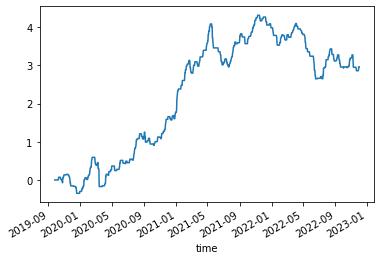

In [522]:
# Plot the Cumulative Returns of this 3rd Trading Strategy
signals_df['cumulative_returns'].plot()